In [185]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May 27 22:15:13 2022

@author: rodrigo
"""

#Cargando librerías 
import importlib

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

import src.positioning_sensors as ps
importlib.reload(ps)

import src.network_fitness as netfit
importlib.reload(netfit)

import src.manageExperiments as me
importlib.reload(me)

from geneticalgorithm import geneticalgorithm as ga

import itertools as it

plt.style.use("ggplot")

setup = me.readConfigFile("config_exp_13062022.txt")


#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"]+setup["input_ntli"]
niveles = setup["folder_input"]+setup["input_evm"]
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y,sigma_x]

#Loading precalculated local and directed empirical variograms

filesv = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+".csv"
filesvmask = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+"mask.csv"

saveOptimumValuesTofile = setup["experiment_id"]+setup["folder_output"]+setup["output_values"]
saveArgsTofile = setup["experiment_id"]+setup["folder_output"]+setup["output_args"]

data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)
variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])


#NLTI: luminance
luminance = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles,invert=True)




nonsat,b = ps.desaturate(luminance,th=setup["desaturation_th"])

variograms = variogram_set.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])
variograms_m = variogram_set_m.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])

coords = np.array(data.iloc[:,1:3])

#nonsat2 = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
#nonsat2 = (nonsat2>=22)*nonsat2

NLTI = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
NLTI = (NLTI>=setup["neglect_values"])*NLTI



#sensitivity = ps.f5(NLTI,EAM,2)
from IPython.display import clear_output

r2 = list([])
results2 = list([])

c=1
sensitivity = ps.f5(NLTI,EAM,c)
aptitude = netfit.NetworkFitness(NLTI,EAM,sensitivity,variograms,variograms_m,coords)



 W = i*a^(p)
Selct cost functions: 
 'xor','max' or 'cover'


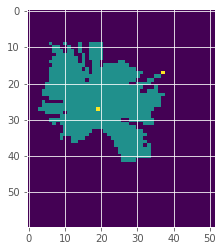

In [193]:
si = (27,19)
sj = (17,37)
ix = aptitude.validate_coordinates(si[0],si[1])
m = np.copy(variograms_m[ix].reshape(NLTI.shape))
m[si]=m[si]+1
m[sj]=m[sj]+1
plt.imshow(m)

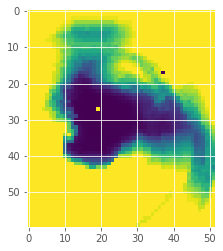

In [194]:
img = np.copy(variograms[ix].reshape(NLTI.shape))
mm = np.copy(variograms[ix].reshape(NLTI.shape))
mm[si] = np.max(variograms[ix].reshape(NLTI.shape))
mm[sj] = 0
plt.imshow(mm)

In [195]:
from skimage.draw import line

rr, cc = line(si[0], si[1], sj[0], sj[1])



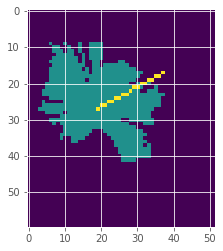

In [209]:
img_line = np.copy(m)

img_line[rr,cc]=2

plt.imshow(img_line)

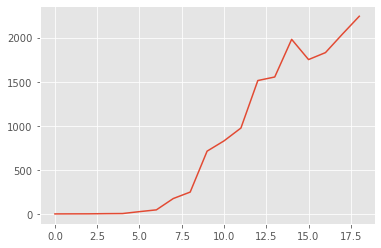

In [201]:
l = list([])


        
for i in range(len(rr)):
            
#    a = (rr[i],cc[i])
            
    l.append(img[(rr[i],cc[i])])
    
plt.plot(l)

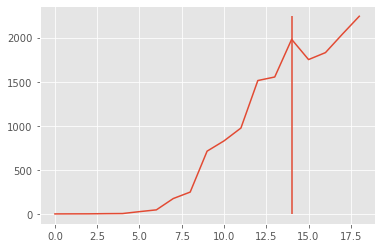

In [215]:

plt.plot(l)
plt.vlines(ps.detectRegion(l,True),ymin=0,ymax=np.max(l))


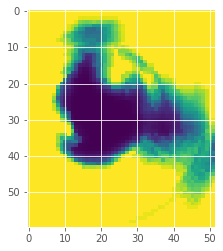

In [218]:
params = {"type": "semivar", 
          "si": si, 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(luminance.shape)

#tell to the class, which object is going to be used to make the semivariogram


rG = rg.rGrowing(nonsat2)

rG.setParams(params)

sv = rG.makeSemivarianceMap(si)

plt.imshow(sv)

Flat Means Decrease  True


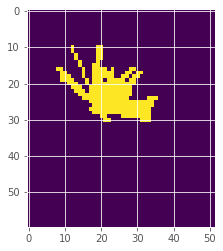

In [225]:
#semivariance mask
fmd = True
print("Flat Means Decrease ", fmd)
sm = ps.constructMask(si,sv,fmd)
plt.imshow(sm)

In [120]:



allc = setup["sensitivity_c"]
alls = setup["nsensors"]
for i in it.product(allc,alls):
    clear_output(wait=False)
    c = i[0]
    n_sensors = i[1]
    print(i)
    
    
    
    aptitude = netfit.NetworkFitness(NLTI,EAM,sensitivity,variograms,variograms_m,coords)
    aptitude.selectFitnessFunction("max")
    f = aptitude.f



    #variable ranges, 2 ranges per sensor position (dim*n_sensors) 
    varbound=np.array([[0,nonsat.shape[0]],[0,nonsat.shape[1]]]*n_sensors)
    print("Search Space Boundaries:", varbound)

    dim = len(varbound)

    #algorithms_parameters={'max_num_iteration': None, 'population_size': 500, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}
#    algorithm_parameters={'max_num_iteration': 1, 'population_size': 2000, 'mutation_probability': 0.1, 'elit_ratio': 0.1, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': 500}
    algorithm_parameters = setup["ga_params"]
    model=ga(function=f,
             dimension=dim,
             algorithm_parameters = algorithm_parameters,
             variable_type='int',
             variable_boundaries=varbound)

    
    
    model.run()
    r2.append(model.output_dict["function"])
    results2.append(model.output_dict["variable"])
    
    res_df= pd.DataFrame(results2)
    res_df.to_csv(saveOptimumValuesTofile)

    res_df= pd.DataFrame(r2)
    res_df.to_csv(saveArgsTofile)

(1, 1)
Selct cost functions: 
 'xor','max' or 'cover'
Search Space Boundaries: [[ 0 60]
 [ 0 52]]
__________________________________________________ 0.3% GA is running...

KeyboardInterrupt: 

In [73]:
s=[0,1,2,3,4,4,4,4]
detectRegion(s,False)


7

In [ ]:
validate_coordinates